# Harikrishna Dev HXD220000

## Setup the environment

In [6]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')

    data_folder =  Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq
    !pip install torchinfo -U -qq

else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

    base_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')
    data_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from pathlib import Path
import sys

# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = model_folder
    # project_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'

# If running locally, specify a different path
else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    custom_function_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

## Required libraries

In [8]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc


from multiclass_lightning_module_v0 import MultiClassLightningModule
from shared_utils import  plot_losses_acc

# Task 1 (2.5 Points): Data Preparation and Augmentation for CIFAR-10

* Load the CIFAR-10 dataset, dividing it into three subsets: train, validation, and test.
* Create a Lightning DataModule for the dataset.

In [9]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random
from collections import defaultdict
import pytorch_lightning as pl


class TransformedSubset(Dataset):
    """
    A Dataset wrapper that applies a transform to a subset of a dataset.

    Attributes:
    subset (Dataset): The subset of data to which the transform will be applied.
    transform (callable, optional): A function/transform to apply to the images.
    """

    def __init__(self, subset, transform=None):
        self.subset = subset  # The original data subset
        self.transform = transform  # The transform function to apply on the data

    def __getitem__(self, index):
        """
        Retrieve and optionally transform the item (image, label) at the given index.

        Parameters:
        index (int): Index of the item to retrieve.

        Returns:
        tuple: Transformed image and label pair.
        """
        # Retrieve original data
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


class CIFAR10MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./cifar10", train_transform=transforms.ToTensor(), test_transform=transforms.ToTensor(),
                 batch_size=64, seed=42, fraction_train=0.8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.seed = seed
        self.fraction_train = fraction_train

    def split_dataset(self, base_dataset):
        split_a_size = int(self.fraction_train * len(base_dataset))
        split_b_size = len(base_dataset) - split_a_size

        return torch.utils.data.random_split(
            base_dataset,
            [split_a_size, split_b_size],
            generator=torch.Generator().manual_seed(self.seed)
        )

    def prepare_data(self):
        # download
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        self.testset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False , download=True
        )
        self.predictset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False, download=True
        )
        self.train_val_set = datasets.CIFAR10(
            self.data_dir, train=True , download=True
        )
        self.trainset, self.validset = self.split_dataset(self.train_val_set)
        self.trainset_transformed = TransformedSubset(self.trainset, self.train_transform)
        self.validset_transformed = TransformedSubset(self.validset, self.test_transform)
        self.testset_transformed = TransformedSubset(self.testset, self.test_transform)

    def train_dataloader(self):
        return DataLoader(
            self.trainset_transformed, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(self.validset_transformed, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testset_transformed, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predictset, batch_size=self.batch_size, shuffle=False)


def get_stratified_subset(dataset, num_samples, seed=None):
    if seed is not None:
        random.seed(seed)

    # Step 1: Identify label distribution
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)

    # Step 2: Calculate proportions and initialize subset indices list
    proportions = {label: len(indices) / len(dataset) for label, indices in label_to_indices.items()}
    subset_indices = []

    # Step 3: Sample according to proportion
    for label, indices in label_to_indices.items():
        num_samples_for_label = round(proportions[label] * num_samples)
        subset_indices += random.sample(indices, num_samples_for_label)

    # Step 4: Combine samples
    return torch.utils.data.Subset(dataset, subset_indices)

# Task 2 (2.5 Points): Fine-Tuning Classifier Layers of VGG16

* Load the pre-trained VGG16 model.
* Adjust and refine the classifier layers of the pre-trained model to tailor it for the CIFAR-10 dataset. Determine the optimal number of classifier layers to unfreeze based on your model's performance requirements.
* OneCycleLR policy for efficient and effective fine-tuning.
Implement data augmentation and preprocessing techniques. Justify each transformation in terms of how it improves model training or generalization. For instance, normalization standardizes pixel values to aid in faster convergence, while random flips or rotations can make the model more robust to variations in input data.
* Present results on the test set, ensuring that this set was excluded from the fine-tuning process.

In [10]:
dm = CIFAR10MNISTDataModule(data_dir=data_folder)
dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [11]:
dm.setup('fit')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
dm.train_dataloader()

In [13]:
data = dm.trainset.dataset.data/255

print(data.mean(axis=(0,1,2)))
print(data.std(axis=(0,1,2)))
print(data.var(axis=(0,1,2)))

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
[0.06102492 0.05928501 0.0684282 ]


In [14]:
normalize = transforms.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784) )
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop([45,45]),
    # transforms.Resize(size=(224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop([50,50]),
    # transforms.RandomRotation(degrees=45),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    # transforms.Resize(size=(224, 224)),
    # transforms.CenterCrop([50,50]),
    normalize,
])

In [15]:
import torchvision.models as models
def load_model(config):
    model = models.vgg16(weights="DEFAULT")

    for param in model.parameters():
        param.requires_grad = False

    if config['f'] != 30:
        for i in range(config['f'],30):
            for param in model.features[i].parameters():
                param.requires_grad = True

    for i in range(config['c'],6):
        for param in model.classifier[i].parameters():
            param.requires_grad = True

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=config['out_features'],bias=True)
    return model

In [16]:
def load_datamodule(config,data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    dm = CIFAR10MNISTDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

In [17]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

In [18]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

In [19]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [20]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

In [21]:
project_folder = custom_function_folder

In [22]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config_cifar10.yaml')
    data_module_config = load_yaml(project_folder/'data_module_cifar10.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config_fminst.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')
    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

In [23]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [24]:
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
model_config

{'model_name': 'vgg16',
 'pretrained': True,
 'out_features': 10,
 'c': 0,
 'f': 30}

In [25]:
data_module_config

{'data_module': {'batch_size': 64, 'seed': 42}}

In [26]:
def count_parameters(model):
  """
  Function to count the number of trainable parameters in the model
  Input: model
  Output: Number of trainable parameters in the input model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
def print_requires_grad(model):
    for name, param in model.named_parameters():
        print(f'{name}: requires_grad={param.requires_grad}')

In [28]:
print_requires_grad(model = load_model(model_config))

features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.2.weight: requires_grad=False
features.2.bias: requires_grad=False
features.5.weight: requires_grad=False
features.5.bias: requires_grad=False
features.7.weight: requires_grad=False
features.7.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
features.12.weight: requires_grad=False
features.12.bias: requires_grad=False
features.14.weight: requires_grad=False
features.14.bias: requires_grad=False
features.17.weight: requires_grad=False
features.17.bias: requires_grad=False
features.19.weight: requires_grad=False
features.19.bias: requires_grad=False
features.21.weight: requires_grad=False
features.21.bias: requires_grad=False
features.24.weight: requires_grad=False
features.24.bias: requires_grad=False
features.26.weight: requires_grad=False
features.26.bias: requires_grad=False
features.28.weight: requires_grad=False
features.28.bias: requires_grad=

In [29]:
load_model(model_config)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Running for one Epoch to check for errors

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to i

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.29, Val_Metric: 0.14 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.40, Train_Metric: 0.06


## Learning rate finder

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.34, Val_Metric: 0.09 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 41.81, Val_Metric: 0.10 | 

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 20 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0006812920690579612
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a64623ff-971d-453d-ab2c-e4ac2cc86ed6.ckpt


Train_Loss: 8.34, Train_Metric: 0.31


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a64623ff-971d-453d-ab2c-e4ac2cc86ed6.ckpt


0.0006812920690579612


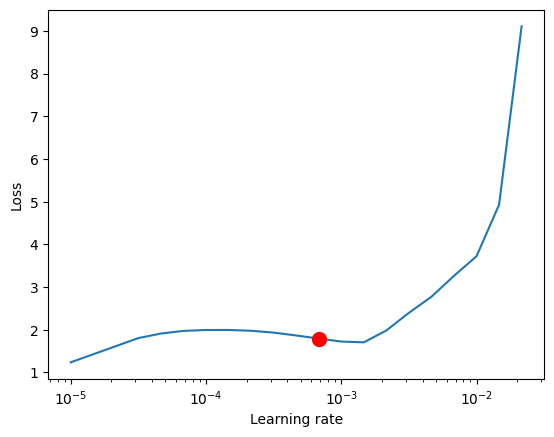

In [ ]:
# Load components
from pytorch_lightning.tuner import Tuner
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config,batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

I had tried the below code block by changing the value is `c` in the `model_config` file. I got the best result as expected by unfreezing the entire classifier

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.2.weight: requires_grad=False
features.2.bias: requires_grad=False
features.5.weight: requires_grad=False
features.5.bias: requires_grad=False
features.7.weight: requires_grad=False
features.7.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
features.12.weight: requires_grad=False
features.12.bias: requires_grad=False
features.14.weight: requires_grad=False
features.14.bias: requires_grad=False
features.17.weight: requires_grad=False
features.17.bias: requires_grad=False
features.19.weight: requires_grad=False
features.19.bias: requires_grad=False
features.21.weight: requires_grad=False
features.21.bias: requires_grad=False
features.24.weight: requires_grad=False
features.24.bias: requires_grad=False
features.26.weight: requires_grad=Fa

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.41, Val_Metric: 0.85 | Train_Loss: 0.74, Train_Metric: 0.75


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.36, Val_Metric: 0.87 | Train_Loss: 0.47, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.33, Val_Metric: 0.88 | Train_Loss: 0.41, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.32, Val_Metric: 0.89 | Train_Loss: 0.36, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.31, Val_Metric: 0.89 | Train_Loss: 0.34, Train_Metric: 0.88


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


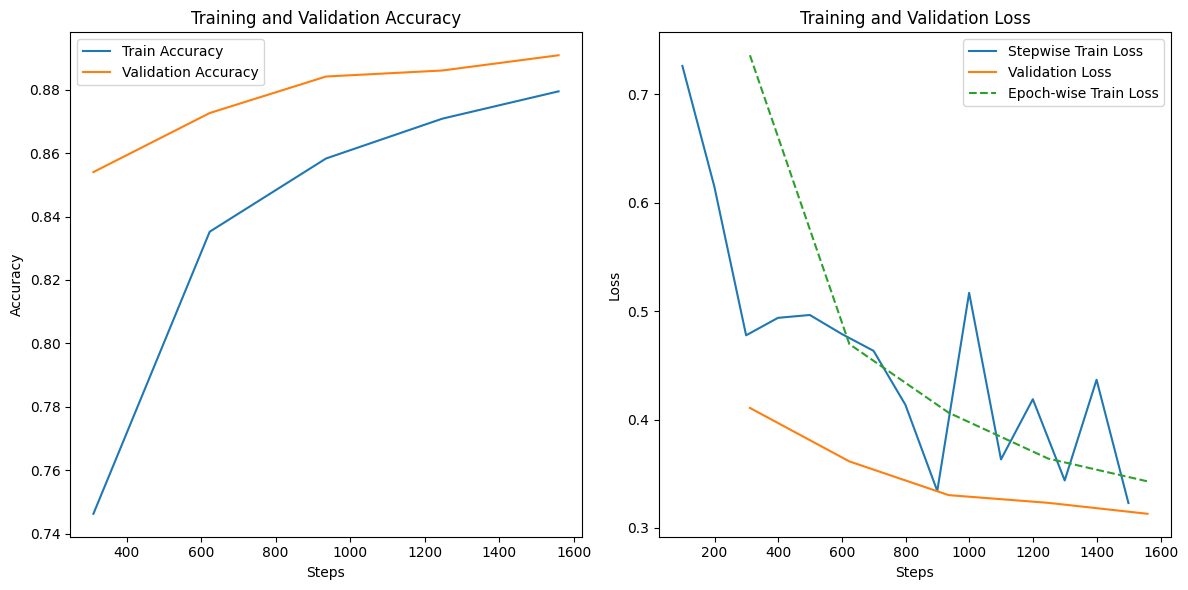

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_85/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_85/checkpoints/epoch=4-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.27, Val_Metric: 0.91 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_85/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_85/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.31, Val_Metric: 0.89 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_85/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_85/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.34, Val_Metric: 0.88 | Train Accuracy: 90.57
Validation Accuracy: 89.08
Test Accuracy: 88.21


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇███
lr-AdamW,▁▁▃▅█
train_loss_epoch,█▃▂▁▁
train_loss_step,█▆▄▄▄▄▃▃▁▄▂▃▁▃▁
train_metric,▁▆▇██
trainer/global_step,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇██████
val_loss,█▅▄▃▃▁▃▄
val_metric,▁▄▅▅▆█▆▅
epoch,5
lr-AdamW,4e-05
train_loss_epoch,0.34293


In [ ]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']=0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='cifar10_multiclass_CNN'
cl_config['wandb']['name']='cifar10_exp1'

# Data Module
data_module_config['data_module']['batch_size']=128
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
print_requires_grad(model=model)
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
test_acc = trainer.validate(dataloaders=dm.predict_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
print(f"Test Accuracy: {test_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Task 3 (2.5 Points): Fine-Tuning from the Last CNN Block in VGG16

* Modify VGG16 by unfreezing from the last CNN block (i.e., features [24] onwards).
* Train the model and report its performance on the test dataset, confirming the absence of test data in training

INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: harikrish0607 (harikrishnad). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.2.weight: requires_grad=False
features.2.bias: requires_grad=False
features.5.weight: requires_grad=False
features.5.bias: requires_grad=False
features.7.weight: requires_grad=False
features.7.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
features.12.weight: requires_grad=False
features.12.bias: requires_grad=False
features.14.weight: requires_grad=False
features.14.bias: requires_grad=False
features.17.weight: requires_grad=False
features.17.bias: requires_grad=False
features.19.weight: requires_grad=False
features.19.bias: requires_grad=False
features.21.weight: requires_grad=False
features.21.bias: requires_grad=False
features.24.weight: requires_grad=True
features.24.bias: requires_grad=True
features.26.weight: requires_grad=True

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
126 M     Trainable params
7.6 M     Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.32, Val_Metric: 0.89 | Train_Loss: 0.62, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.27, Val_Metric: 0.90 | Train_Loss: 0.34, Train_Metric: 0.88


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.26, Val_Metric: 0.91 | Train_Loss: 0.26, Train_Metric: 0.91


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.24, Val_Metric: 0.92 | Train_Loss: 0.22, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.24, Val_Metric: 0.92 | Train_Loss: 0.19, Train_Metric: 0.94


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


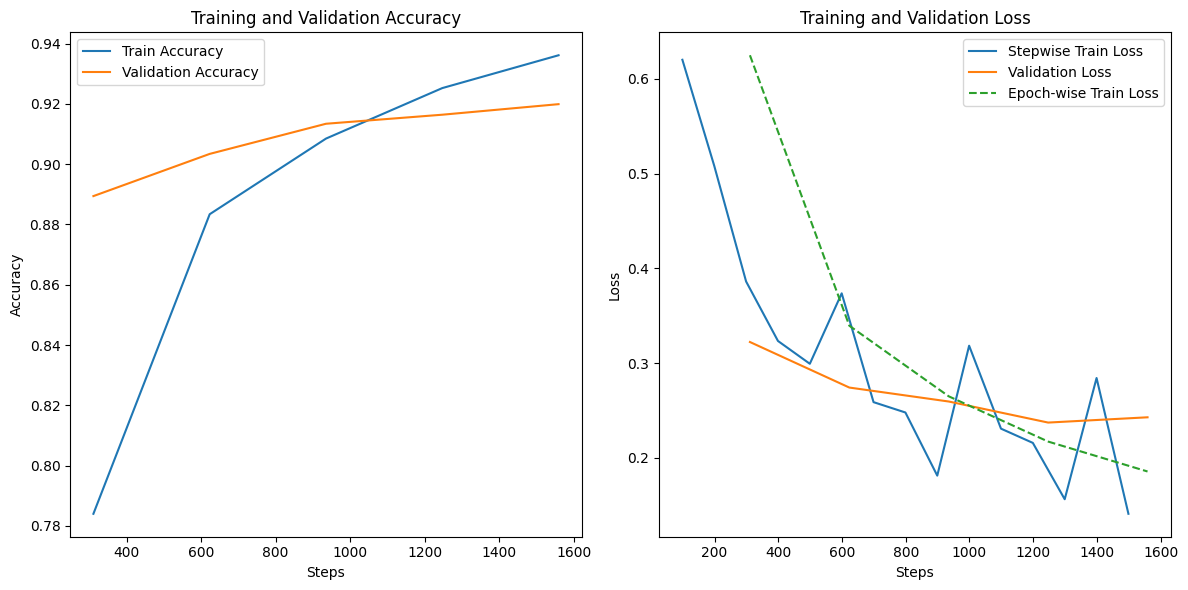

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_86/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_86/checkpoints/epoch=4-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.13, Val_Metric: 0.96 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_86/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_86/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.24, Val_Metric: 0.92 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_86/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_86/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.26, Val_Metric: 0.92 | Train Accuracy: 95.82
Validation Accuracy: 91.99
Test Accuracy: 91.67


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇███
lr-AdamW,▁▁▃▅█
train_loss_epoch,█▃▂▂▁
train_loss_step,█▆▅▄▃▄▃▃▂▄▂▂▁▃▁
train_metric,▁▆▇▇█
trainer/global_step,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇██████
val_loss,█▆▆▅▅▁▅▆
val_metric,▁▂▃▄▄█▄▄
epoch,5
lr-AdamW,4e-05
train_loss_epoch,0.18565


In [ ]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']=0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='cifar10_multiclass_CNN'
cl_config['wandb']['name']='cifar10_exp2'

# Data Module
data_module_config['data_module']['batch_size']=128

# Model config
model_config['f'] = 24

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
print_requires_grad(model=model)
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
test_acc = trainer.validate(dataloaders=dm.predict_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
print(f"Test Accuracy: {test_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Task 4 (2.5 Points): Fine-Tuning from the Last Two CNN Blocks in VGG16

* Adjust the VGG16 model to unfreeze from the last two CNN blocks (i.e., features [17] onwards).
* Evaluate and compare the test set results with those from Tasks 2 and 3 to determine the most effective strategy.
* Aim for at least 90% accuracy across tasks 2,3 and 4 i.e. at least one of the task should have 90% accuracy

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.2.weight: requires_grad=False
features.2.bias: requires_grad=False
features.5.weight: requires_grad=False
features.5.bias: requires_grad=False
features.7.weight: requires_grad=False
features.7.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
features.12.weight: requires_grad=False
features.12.bias: requires_grad=False
features.14.weight: requires_grad=False
features.14.bias: requires_grad=False
features.17.weight: requires_grad=True
features.17.bias: requires_grad=True
features.19.weight: requires_grad=True
features.19.bias: requires_grad=True
features.21.weight: requires_grad=True
features.21.bias: requires_grad=True
features.24.weight: requires_grad=True
features.24.bias: requires_grad=True
features.26.weight: requires_grad=True
featu

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
132 M     Trainable params
1.7 M     Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.30, Val_Metric: 0.90 | Train_Loss: 0.58, Train_Metric: 0.80


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.29, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.23, Val_Metric: 0.92 | Train_Loss: 0.21, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.22, Val_Metric: 0.93 | Train_Loss: 0.17, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.21, Val_Metric: 0.93 | Train_Loss: 0.14, Train_Metric: 0.95


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


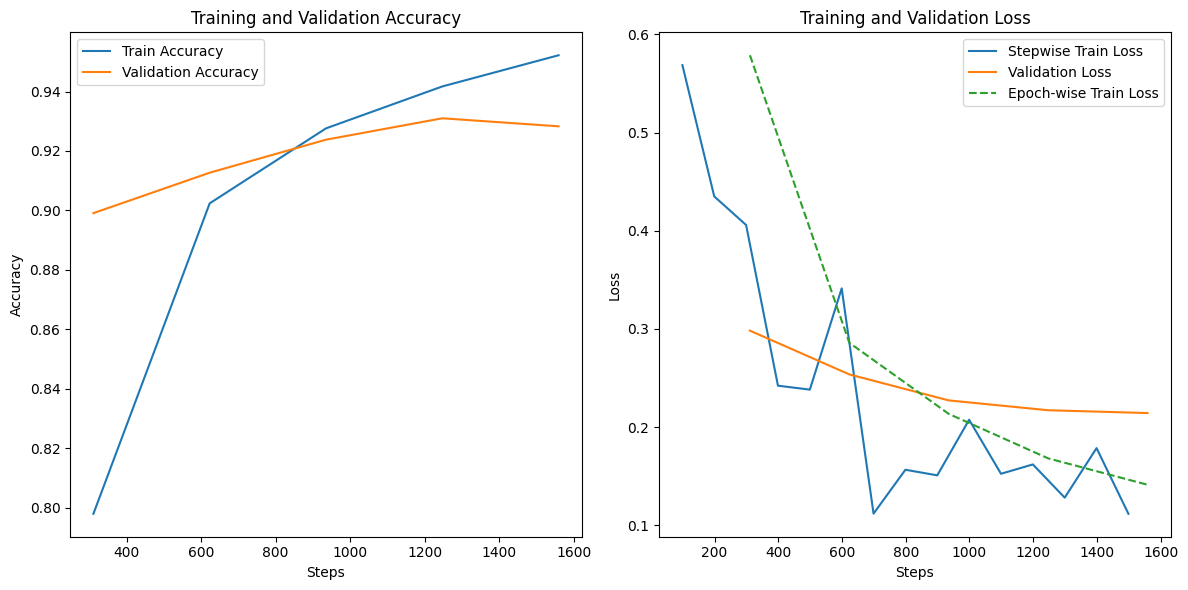

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_89/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_89/checkpoints/epoch=4-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.10, Val_Metric: 0.97 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_89/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_89/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.21, Val_Metric: 0.93 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_89/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_89/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.23, Val_Metric: 0.92 | Train Accuracy: 96.79
Validation Accuracy: 92.83
Test Accuracy: 92.43


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇███
lr-AdamW,▁▁▃▅█
train_loss_epoch,█▃▂▁▁
train_loss_step,█▆▆▃▃▅▁▂▂▂▂▂▁▂▁
train_metric,▁▆▇██
trainer/global_step,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇██████
val_loss,█▆▆▅▅▁▅▆
val_metric,▁▂▄▄▄█▄▄
epoch,5
lr-AdamW,4e-05
train_loss_epoch,0.14127


In [ ]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']=0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='cifar10_multiclass_CNN'
cl_config['wandb']['name']='cifar10_exp3'

# Data Module
data_module_config['data_module']['batch_size']=128

# Model config
model_config['f'] = 17

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
print_requires_grad(model=model)
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
test_acc = trainer.validate(dataloaders=dm.predict_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
print(f"Test Accuracy: {test_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Task 5 (5 Points): Dynamic Learning Rate Adjustment

* Experiment with different learning rates for various layers during each epoch. Refer to the provided tutorial for implementation strategies. This advanced technique can lead to more nuanced and effective model training. (See the link here : https://github.com/Paperspace/PyTorch-101-Tutorial-Series/blob/master/PyTorch%20101%20Part%203%20-%20Advance%20PyTorch%20Usage.ipynb )

In [ ]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']= 0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}


# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='cifar10_multiclass_CNN'
cl_config['wandb']['name']='cifar10_exp4'

# Data Module
data_module_config['data_module']['batch_size']=128

# Model config
model_config['f'] = 17

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
print_requires_grad(model)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.2.weight: requires_grad=False
features.2.bias: requires_grad=False
features.5.weight: requires_grad=False
features.5.bias: requires_grad=False
features.7.weight: requires_grad=False
features.7.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
features.12.weight: requires_grad=False
features.12.bias: requires_grad=False
features.14.weight: requires_grad=False
features.14.bias: requires_grad=False
features.17.weight: requires_grad=True
features.17.bias: requires_grad=True
features.19.weight: requires_grad=True
features.19.bias: requires_grad=True
features.21.weight: requires_grad=True
features.21.bias: requires_grad=True
features.24.weight: requires_grad=True
features.24.bias: requires_grad=True
features.26.weight: requires_grad=True
featu

In [ ]:
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)
    print(f'{idx}: {name}')

0: features.0.weight
1: features.0.bias
2: features.2.weight
3: features.2.bias
4: features.5.weight
5: features.5.bias
6: features.7.weight
7: features.7.bias
8: features.10.weight
9: features.10.bias
10: features.12.weight
11: features.12.bias
12: features.14.weight
13: features.14.bias
14: features.17.weight
15: features.17.bias
16: features.19.weight
17: features.19.bias
18: features.21.weight
19: features.21.bias
20: features.24.weight
21: features.24.bias
22: features.26.weight
23: features.26.bias
24: features.28.weight
25: features.28.bias
26: classifier.0.weight
27: classifier.0.bias
28: classifier.3.weight
29: classifier.3.bias
30: classifier.6.weight
31: classifier.6.bias


In [ ]:
lr      = 1e-3
lr_mult = 0.9

# placeholder
parameters = []

c=0

# store params & learning rates
for idx, name in enumerate(layer_names):

    if c < model_config['c']:

      lr = lr

      c+=1

    else:

      # append layer parameters
      parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]
      lr /= lr_mult

      # update learning rate
      c+=1

      # display info
      print(f'{idx}: lr = {lr:.6f}, {name}')

0: lr = 0.001111, features.0.weight
1: lr = 0.001235, features.0.bias
2: lr = 0.001372, features.2.weight
3: lr = 0.001524, features.2.bias
4: lr = 0.001694, features.5.weight
5: lr = 0.001882, features.5.bias
6: lr = 0.002091, features.7.weight
7: lr = 0.002323, features.7.bias
8: lr = 0.002581, features.10.weight
9: lr = 0.002868, features.10.bias
10: lr = 0.003187, features.12.weight
11: lr = 0.003541, features.12.bias
12: lr = 0.003934, features.14.weight
13: lr = 0.004371, features.14.bias
14: lr = 0.004857, features.17.weight
15: lr = 0.005397, features.17.bias
16: lr = 0.005996, features.19.weight
17: lr = 0.006662, features.19.bias
18: lr = 0.007403, features.21.weight
19: lr = 0.008225, features.21.bias
20: lr = 0.009139, features.24.weight
21: lr = 0.010155, features.24.bias
22: lr = 0.011283, features.26.weight
23: lr = 0.012537, features.26.bias
24: lr = 0.013930, features.28.weight
25: lr = 0.015477, features.28.bias
26: lr = 0.017197, classifier.0.weight
27: lr = 0.019108

In [ ]:
lightning_module_config['others']['optimizer_params'] = parameters

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
132 M     Trainable params
1.7 M     Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.30, Val_Metric: 0.90 | Train_Loss: 0.58, Train_Metric: 0.80


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.29, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.23, Val_Metric: 0.92 | Train_Loss: 0.21, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.22, Val_Metric: 0.93 | Train_Loss: 0.17, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.21, Val_Metric: 0.93 | Train_Loss: 0.14, Train_Metric: 0.95


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


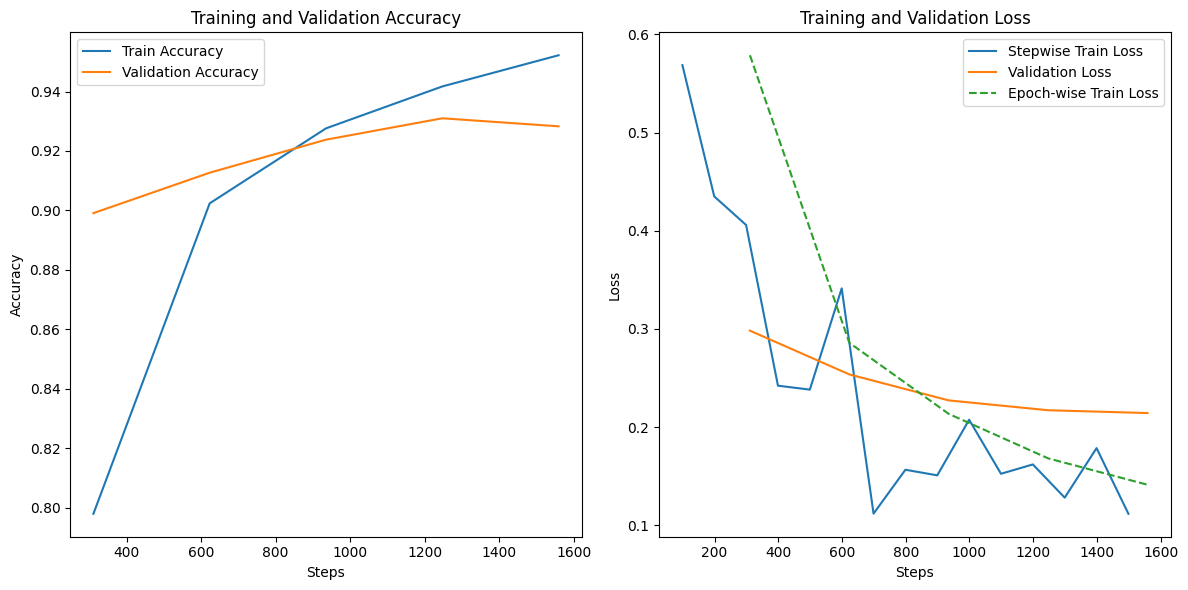

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_93/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_93/checkpoints/epoch=4-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.21, Val_Metric: 0.93 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_93/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_93/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.23, Val_Metric: 0.92 | Validation Accuracy: 92.83
Test Accuracy: 92.43


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
lr-AdamW,▁▁▁▃▅█
train_loss_epoch,█▃▂▁▁
train_loss_step,█▆▆▃▃▅▁▂▂▂▂▂▁▂▁
train_metric,▁▆▇██
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇█████
val_loss,█▄▂▁▁▁▂
val_metric,▁▄▆█▇▇▇
epoch,5
lr-AdamW,4e-05
train_loss_epoch,0.14127


In [ ]:
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
# train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
test_acc = trainer.validate(dataloaders=dm.predict_dataloader(), ckpt_path=ckpt_path, verbose=False)
# print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
print(f"Test Accuracy: {test_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Task 6 (5 Points): Experimenting with a Different Pre-Trained Model

* Choose a different pre-trained model and adapt it for CIFAR-10.
    * Try atleast one model from convnext family
    * Try atleast one model from Resnet family
* Aim for a minimum accuracy of 94% on the test set. This task encourages exploration of different architectures and their suitability for the CIFAR-10 dataset.

## Resnet model

In [44]:
import torchvision.models as models
def load_model(config):
    model = models.resnet34(weights='DEFAULT')

    for param in model.parameters():
        param.requires_grad = False

    # for i, requires_grad in enumerate(config['classifier']):
    #     if requires_grad:
    #         model.classifier[i].requires_grad_(True)
    for param in model.layer3.parameters():
        param.requires_grad = True

    for param in model.layer4.parameters():
        param.requires_grad = True

    # if i > 0:
    #   c = 0
    #   for param in model.parameters():
    #     c+=1
    #     if c>i:
    #         param.requires_grad = True
    model.fc = nn.Linear(512, config['output_size'],bias=True)
    return model

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer1.2.conv1.weight: requires_grad=False
layer1.2.bn1.weight: requires_grad=False
layer1.2.bn1.bias: requires_grad=False
layer1.2.conv2.weight: requires_grad=False
layer1.2.bn2.weight: requires_grad=False
layer1.2.bn2.bias: requires_grad=False
layer2.0.conv1.weight: requires_grad=False
layer2.0.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ResNet             | 21.3 M
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
19.9 M    Trainable params
1.3 M     Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.76, Val_Metric: 0.09 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.20, Val_Metric: 0.93 | Train_Loss: 0.47, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.17, Val_Metric: 0.94 | Train_Loss: 0.18, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.15, Val_Metric: 0.95 | Train_Loss: 0.12, Train_Metric: 0.96


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.15, Val_Metric: 0.95 | Train_Loss: 0.09, Train_Metric: 0.97


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.16, Val_Metric: 0.95 | Train_Loss: 0.07, Train_Metric: 0.98


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


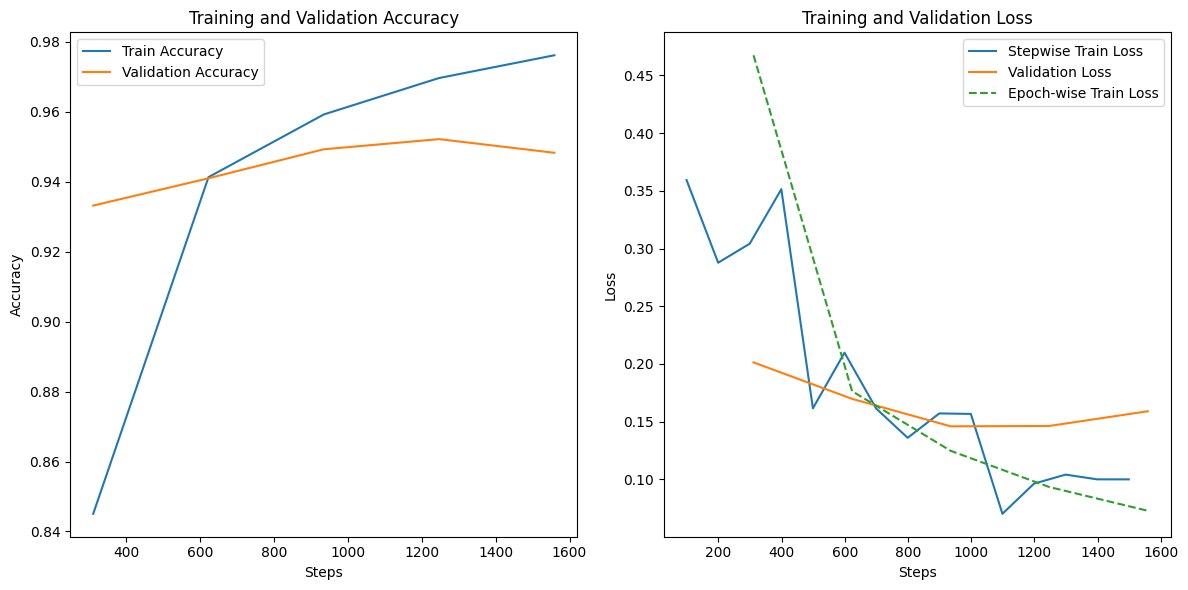

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_98/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_98/checkpoints/epoch=4-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.16, Val_Metric: 0.95 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_98/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_98/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.18, Val_Metric: 0.94 | Validation Accuracy: 94.83
Test Accuracy: 94.46


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
lr-AdamW,▁▁▃▅█
train_loss_epoch,█▃▂▁▁
train_loss_step,█▆▇█▃▄▃▃▃▃▁▂▂▂▂
train_metric,▁▆▇██
trainer/global_step,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇█████
val_loss,█▄▁▁▃▃▅
val_metric,▁▄▇█▇▇▅
epoch,5
lr-AdamW,4e-05
train_loss_epoch,0.0728


In [46]:
# Load components

free_memory()
seed_everything(42)
_, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']=0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='cifar10_multiclass_CNN'
cl_config['wandb']['name']='cifar10_exp5'

# Data Module
data_module_config['data_module']['batch_size']=128

# Model config
model_config = {'output_size': 10}

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
print_requires_grad(model=model)
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
# train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
test_acc = trainer.validate(dataloaders=dm.predict_dataloader(), ckpt_path=ckpt_path, verbose=False)
# print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
print(f"Test Accuracy: {test_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

## Convnext model

In [50]:
import torchvision.models as models
def load_model(config):
    model = models.convnext_tiny(weights='DEFAULT')

    for param in model.parameters():
        param.requires_grad = False

    # for i, requires_grad in enumerate(config['classifier']):
    #     if requires_grad:
    #         model.classifier[i].requires_grad_(True)
    for param in model.features[7].parameters():
        param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    # if i > 0:
    #   c = 0
    #   for param in model.parameters():
    #     c+=1
    #     if c>i:
    #         param.requires_grad = True
    model.classifier[2] = nn.Linear(768, config['output_size'],bias=True)
    return model

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
features.0.0.weight: requires_grad=False
features.0.0.bias: requires_grad=False
features.0.1.weight: requires_grad=False
features.0.1.bias: requires_grad=False
features.1.0.layer_scale: requires_grad=False
features.1.0.block.0.weight: requires_grad=False
features.1.0.block.0.bias: requires_grad=False
features.1.0.block.2.weight: requires_grad=False
features.1.0.block.2.bias: requires_grad=False
features.1.0.block.3.weight: requires_grad=False
features.1.0.block.3.bias: requires_grad=False
features.1.0.block.5.weight: requires_grad=False
features.1.0.block.5.bias: requires_grad=False
features.1.1.layer_scale: requires_grad=False
features.1.1.block.0.weight: requires_grad=False
features.1.1.block.0.bias: requires_grad=False
features.1.1.block.2.weight: requires_grad=False
features.1.1.block.2.bias: requires_grad=False
features.1.1.block.3.weight: requires_grad=False
features.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ConvNeXt           | 27.8 M
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
14.3 M    Trainable params
13.5 M    Non-trainable params
27.8 M    Total params
111.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.28, Val_Metric: 0.21 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.17, Val_Metric: 0.94 | Train_Loss: 0.63, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.14, Val_Metric: 0.95 | Train_Loss: 0.21, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.12, Val_Metric: 0.96 | Train_Loss: 0.16, Train_Metric: 0.95


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.12, Val_Metric: 0.96 | Train_Loss: 0.13, Train_Metric: 0.96


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.11, Val_Metric: 0.96 | Train_Loss: 0.11, Train_Metric: 0.96


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


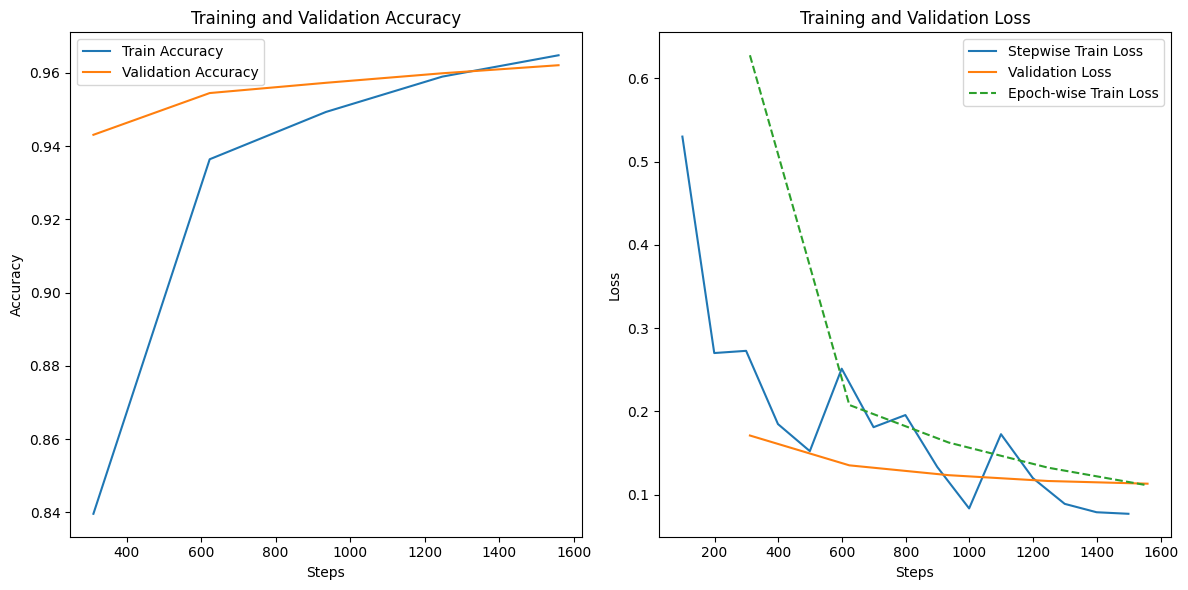

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_99/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_99/checkpoints/epoch=4-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.11, Val_Metric: 0.96 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_99/checkpoints/epoch=4-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_99/checkpoints/epoch=4-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.13, Val_Metric: 0.96 | Validation Accuracy: 96.21
Test Accuracy: 95.69


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
lr-AdamW,▁▁▃▅█
train_loss_epoch,█▂▂▁▁
train_loss_step,█▄▄▃▂▄▃▃▂▁▂▂▁▁▁
train_metric,▁▆▇██
trainer/global_step,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇█████
val_loss,█▄▂▁▁▁▃
val_metric,▁▅▆▇██▆
epoch,5
lr-AdamW,4e-05
train_loss_epoch,0.111


In [54]:
# Load components

free_memory()
seed_everything(42)
_, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']=0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='cifar10_multiclass_CNN'
cl_config['wandb']['name']='cifar10_exp6'

# Data Module
data_module_config['data_module']['batch_size']=128

# Model config
model_config = {'output_size': 10}

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
print_requires_grad(model=model)
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
# train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
test_acc = trainer.validate(dataloaders=dm.predict_dataloader(), ckpt_path=ckpt_path, verbose=False)
# print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
print(f"Test Accuracy: {test_acc[0]['val_metric']*100:0.2f}")
wandb.finish()